Back to the main [Index](../index.ipynb) <a id="top"></a>

<div class="jumbotron">
  <h1 class="display-3">First (basic) lesson with Abinit and AbiPy</h1>
  <p class="lead">The H<sub>2</sub> molecule</p> 
  <hr class="my-4">
  <p>This lesson aims at showing how to get the following physical properties:</p>
      
   <ul>
    <li>the (pseudo) total energy</li>
    <li>the bond length</li>
    <li>the charge density</li>
    <li>the atomisation energy</li>
   </ul>
</div>

There are three methodologies to compute the optimal distance between the two Hydrogen atoms. One could:

   * compute the **total energy** for different values of the interatomic distance, make a fit through 
      the different points, and determine the minimum of the fitting function;
   * compute the **forces** for different values of the interatomic distance, make a fit through 
      the different values, and determine the zero of the fitting function;
   * use an automatic algorithm for minimizing the energy (or finding the zero of forces)

In this AbiPy notebook, we will be focusing on the first approach.
More specifically we will build an AbiPy `Flow` to compute the energy and the forces in the $H_2$ molecule 
for different values of the interatomic distance. 
This exercise allows us to learn how to generate multiple input files in python and 
how to analyze multiple ground-state calculations with the AbiPy robots.


## Table of Contents
[[back to top](#top)]

* [Our first AbiPy function](#Our-first-AbiPy-function)
* [Computation of the interatomic distance](#Computation-of-the-interatomic-distance)
* [Analyzing the main output file](#Analyzing-the-main-output-file)
* [Extracting results from the GSR files](#Extracting-results-from-the-GSR-files)
* [Analysis of the charge density](#Analysis-of-the-charge-density)
* [Conclusions](#Conclusions)

## Our first AbiPy function
[[back to top](#top)]

In [1]:
# Use this at the beginning of your script so that your code will be compatible with python3
from __future__ import print_function, division, unicode_literals

import numpy as np  

import warnings 
warnings.filterwarnings("ignore")  # Ignore warnings

from abipy import abilab
abilab.enable_notebook() # This line tells AbiPy we are running inside a notebook

# This line tells the notebook to show plots inside of the notebook
%matplotlib notebook

We need a function that generates an input file for a GS calculations for the $H_2$ molecule in a big box.
Ideally a function that receives the distance `x`, the cutoff energy `ecut` and the size of the big box 
in input so that we can customize the output and generate multiple input objects easily.

Fortunately we already have such a function in the `lesson_base1.py` module.
Let's import it and look at the code:

In [2]:
from lesson_base1 import gs_input
abilab.print_source(gs_input)

If the function is called without arguments, the default values (specified in the prototype) are used. 
Let's try:

In [3]:
gsinp = gs_input()
print("The value of ecut is:", gsinp["ecut"])

The value of ecut is: 10


The `AbinitInput` is a dict-like object whose usage is documented in this [notebook](../abinit_input.ipynb).
Inside jupyter, we can get the HTML representation of the input with:

In [4]:
gsinp

<AbinitInput at 25935923968>

The input object can be converted into a string. 
More importantly, an `AbinitInput` *has* an AbiPy structure
(see [Structure notebook](../structure.ipynb)), 
a list of pseudopotential objects and provides several methods 
to facilitate the specification of input variables.

In [6]:
print(gsinp.structure)
print("The big box volume is:", gsinp.structure.volume)

Full Formula (H2)
Reduced Formula: H2
abc   :   5.291772   5.291772   5.291772
angles:  90.000000  90.000000  90.000000
Sites (2)
  #  SP        a    b    c
---  ----  -----  ---  ---
  0  H     -0.07    0    0
  1  H      0.07    0    0
The big box volume is: 148.18471127642286


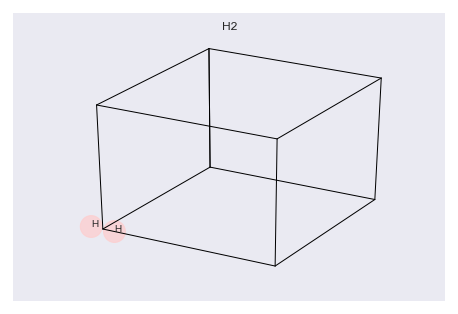

In [7]:
gsinp.structure.plot();

Let's print some info about our pseudopotentials:

In [9]:
print(gsinp.pseudos[0])

<NcAbinitPseudo: 01h.pspgth>
  summary: Goedecker-Teter-Hutter  Wed May  8 14:27:44 EDT 1996
  number of valence electrons: 1.0
  maximum angular momentum: s
  angular momentum for local part: s
  XC correlation: LDA_XC_TETER93
  supports spin-orbit: False
  radius for non-linear core correction: 0.0
  hint for low accuracy: ecut: 0.0, pawecutdg: 0.0
  hint for normal accuracy: ecut: 0.0, pawecutdg: 0.0
  hint for high accuracy: ecut: 0.0, pawecutdg: 0.0


## Computation of the interatomic distance
[[back to top](#top)]

At this point, we can use `gs_input` to generate an [Abinit Flow](../flows.ipynb)
to compute the total energy and the forces of H-H with different interatomic distances. 
We have already prepared such a function in `build_flow`, let's have a look at the code:

In [10]:
from lesson_base1 import build_flow
abilab.print_source(build_flow)

Note that we are working at fixed `ecut` and `acell`, only the H-H distance is modified.
Let's call the function to build our flow:

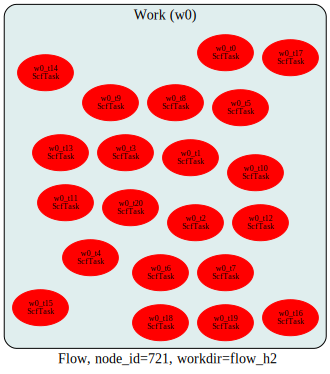

In [11]:
flow = build_flow(options=None)
flow.get_graphviz()

Ok, so far so sood. 
With just three lines of codes and our `gs_input` function, we managed 
to construct an AbiPy flow for the $H_2$ molecule.
Let's write some python code to check that we really obtained what we had in mind:

In [12]:
inputs = [task.input for task in flow.iflat_tasks()]

print("ecuts:\n", [inp["ecut"] for inp in inputs])

print("vols:\n", ["%.1f" % inp.structure.volume for inp in inputs])

def hh_dist(structure):
    return np.linalg.norm(structure.cart_coords[1] - structure.cart_coords[0])

from pprint import pprint
print("h-h [Ang]:\n", ["%.3f" % hh_dist(inp.structure) for inp in inputs])

ecuts:
 [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
vols:
 ['148.2', '148.2', '148.2', '148.2', '148.2', '148.2', '148.2', '148.2', '148.2', '148.2', '148.2', '148.2', '148.2', '148.2', '148.2', '148.2', '148.2', '148.2', '148.2', '148.2', '148.2']
h-h [Ang]:
 ['0.529', '0.557', '0.585', '0.613', '0.640', '0.668', '0.696', '0.724', '0.751', '0.779', '0.807', '0.835', '0.863', '0.890', '0.918', '0.946', '0.974', '1.001', '1.029', '1.057', '1.085']


At this point, we could run the flow in the notebook by just calling:

    flow.make_scheduler().start()

or, alternatively, execute the `lesson_base1.py` script to build 
the directory with the flow and then use:

    abirun.py flow_h2 scheduler

inside the terminal.

<!--
we postpone the discussion of this part because we should first create two YAML configuration files
with options defining the execution environment and the submission policy.
(For a detailed explanation of the AbiPy configuration files, please consult the
[TaskManager documentation](http://abinit.github.io/abipy/workflows/taskmanager.html).

There are only three points that we need to understand before proceeding with the next sections:

* A `Flow` is a list of `Worflows` objects and each `Workflow` is a list of `Tasks`
* Each `Task` is associated to an `AbinitInput` object
* Tasks are executed in different directories with a predefined structure.
* A `Task` can depend on other tasks and this information must be encoded in the `Flow` so that AbiPy can manage the execution. Our first example does not have dependencies. 

Armed with these concepts, we can finally start to use `abiopen` to analyze the output files of our `Flow`.
-->

Let's assume the flow has been already executed and let's focus on the analysis of the final results.

## Analyzing the main output file
[[back to top](#top)]

First of all, it's always a good idea to check whether the SCF cycle is converged.
Obviously one could open the main output file, find the SCF iterations and look for warnings but
there's a much faster (and better) way to do that with AbiPy:

In [13]:
abo = abilab.abiopen("flow_h2/w0/t0/run.abo")
print(abo)

ndtset: 1, completed: True
Full Formula (H2)
Reduced Formula: H2
abc   :   5.291772   5.291772   5.291772
angles:  90.000000  90.000000  90.000000
Sites (2)
  #  SP        a    b    c
---  ----  -----  ---  ---
  0  H     -0.05    0    0
  1  H      0.05    0    0

Abinit Spacegroup: spgid: 123, num_spatial_symmetries: 16, has_timerev: True, symmorphic: False


To get the list of Warnings/Comments/Errors:

In [14]:
print(abo.events)

Events found in /Users/gonze/_Research/Abitutorials_git/abitutorials/abitutorials/base1/flow_h2/w0/t0/run.abo

num_errors: 0, num_warnings: 0, num_comments: 0, completed: False



To plot the SCF cycle, use:


Loading all matplotlib figures before showing them. It may take some time...
All figures in memory, elapsed time: 0.425 s


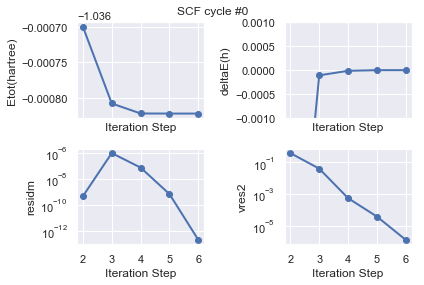

In [15]:
abo.plot();

Since this is not a structural relaxation, the initial and final structures must be equal:

In [16]:
abo.initial_structure == abo.final_structure

True

The basic dimensions and parameters of the run can be extracted from the output file with:

In [17]:
abo.get_dims_spginfo_dataset()

(OrderedDict([(1,
               OrderedDict([('intxc', 0),
                            ('ionmov', 0),
                            ('iscf', 7),
                            ('lmnmax', 1),
                            ('lnmax', 1),
                            ('mgfft', 30),
                            ('mpssoang', 1),
                            ('mqgrid', 3001),
                            ('natom', 2),
                            ('nloc_mem', 1),
                            ('nspden', 1),
                            ('nspinor', 1),
                            ('nsppol', 1),
                            ('nsym', 16),
                            ('n1xccc', 0),
                            ('ntypat', 1),
                            ('occopt', 1),
                            ('xclevel', 1),
                            ('mband', 1),
                            ('mffmem', 1),
                            ('mkmem', 1),
                            ('mpw', 752),
                            ('nfft',

Within the shell, one can use:

    abiview.py abo flow_h2/w0/t0/run.abo
    
to plot the SCF cycle or

    abiopen.py flow_h2/w0/t0/run.abo

to open the file and start the ipython terminal

<!--
Note that the object returned by `abiopen` has an associated file descriptor that should be closed 
explictly by the user with `abo.close()`. 
This is the reason why many examples will use the python context manager:
    
```python
    with abiopen("path") as abifile:
        print(abifile)
```
        
that closes the `abifile` object when we exit the `with` block.
-->

## Extracting results from the GSR files
[[back to top](#top)]

The ground-state results are saved in the `GSR.nc` files whose API is extensively
discussed in the [GSR notebook](../gsr.ipynb).

Let's have a look at the results produced by the first task:

In [18]:
with abilab.abiopen("flow_h2/w0/t0/outdata/out_GSR.nc") as gsr:
    print(gsr)

================================= File Info =================================
Name: out_GSR.nc
Directory: /Users/gonze/_Research/Abitutorials_git/abitutorials/abitutorials/base1/flow_h2/w0/t0/outdata
Size: 8.20 kb
Access Time: Sat Jul 28 21:22:20 2018
Modification Time: Fri Jul 27 08:57:21 2018
Change Time: Fri Jul 27 08:57:21 2018

================================= Structure =================================
Full Formula (H2)
Reduced Formula: H2
abc   :   5.291772   5.291772   5.291772
angles:  90.000000  90.000000  90.000000
Sites (2)
  #  SP        a    b    c  cartesian_forces
---  ----  -----  ---  ---  --------------------------------------------------
  0  H     -0.05    0    0  [-19.54779666  -0.          -0.        ] eV ang^-1
  1  H      0.05    0    0  [19.54779666 -0.         -0.        ] eV ang^-1

Abinit Spacegroup: spgid: 123, num_spatial_symmetries: 16, has_timerev: True, symmorphic: False

Stress tensor (Cartesian coordinates in Ha/Bohr**3):
[[-3.65644463e-04  0.000000

As we can see from the previous output, the `GSR` file contains information about 
the crystalline structure, forces, stresses as well as the KS band structure.
In the jargon of object-oriented programming, one says that a `GSRFile` *has* a `Structure` object:
    
        gsr.structure
        
and *has* an `ElectronBands` object:
    
        gsr.ebands
        
This means that if you learn how to use the methods provided by `structure` and `ebands`, then you can 
easily get these objects from the `GSR` file and use this API to post-process the results.
This is a general philosophy of AbiPy: every netcdf file object returned by `abiopen` contains
other objects (the structure is always available, while the presence of other objects depend of the particular file). 
Remember this point because we'll use it in the other lessons.

Ok, now we know how to open and extract information from one `GSR` file.
In this tutorial, however, we need to analyze multiple `GSR` files!
If you are familiar with python, it should not be difficult to write a `for loop` that 
iterates over a list of GSR files, extracts the total energy with the corresponding volume and creates two
lists that can be used to plot $E(d_{H-H})$.
This kind of operations are, however, very common and AbiPy provides a high-level interface (`robots`) to
operate on multiple files and post-process the data.

In the simplest case, the `Robot` finds all files of a particular type located within a directory tree,
stores all the data in memory and exposes methods to extract/post-process the results.

In [ ]:
robot = abilab.GsrRobot.from_dir("flow_h2")
robot

In [ ]:
table = robot.get_dataframe()

The table contains several columns:

In [ ]:
table.keys()

Inside the notebook, we can visualize the table with:

In [ ]:
table

Great! We managed to get a nice table with lot of useful results with just 3 lines of code and the robot!
There are however two problems:
    
   - The rows of the table are not ordered by volume (files are sorted alphabetically)
   
   - Our dataframe contains the energy of the different configurations but we would like to plot the energy 
     as a function of the H-H distance
   
Well, robots can do a lot of hard work but they are a little bit stupid so 
we have to tell them what to do with the data. 
More specifically we need a way to tell the robot that, for each `GSR` file, it should get the crystalline 
structure, compute the distance between the first and the second atom and insert the result 
in our table in a given column.
This kind of tasks are usually executed with `callbacks` i.e. functions that are passed in input
and **automatically executed** by the framework at runtime. 

<img src="https://github.com/abinit/abipy_assets/blob/master/caution-machine_has_no_brain.jpg?raw=true" alt="">

Let's look at the documentation of `robot.get_dataframe`:

In [ ]:
help(robot.get_dataframe)

It seems complicated but the actual implementation of the callback is just three lines of code:

In [ ]:
def hh_dist(gsr):
    """
    This callback receives a GSR file and computes the H-H distance.
    The robot will call this function to compute the H-H distance, 
    and return a (key, value) tuple that will be inserted in the pandas DataFrame.
    """
    cart_coords = gsr.structure.cart_coords
    d = np.linalg.norm(cart_coords[1] - cart_coords[0])
    return "hh_dist", d

with abilab.GsrRobot.from_dir("flow_h2") as robot:
    table = robot.get_dataframe(funcs=hh_dist)
    table = table.sort_values(by="hh_dist")  

As expected, now the table contains a new column with `hh_dist` in Angstrom:

In [ ]:
"hh_dist" in table

Let's print the two columns with the H-H distance and the total energy:

In [ ]:
table[["hh_dist", "energy"]]

Note that the energy in our `DataFrame` is given in eV to facilitate the integration 
with `pymatgen` that uses eV for energies and Angstrom for lengths.
Let's add another column to our table with energies in Hartree:

In [ ]:
table["energy_Ha"] = table["energy"] * abilab.units.eV_to_Ha

and use the `plot` method of pandas `DataFrames` to plot `energy_Ha` vs `hh_dist`  

In [ ]:
table.plot(x="hh_dist", y="energy_Ha", style="-o");

At this point, it should be clear that to plot the maximum of the forces as a function of the H-H distance
we just need:

In [ ]:
table.plot(x="hh_dist", y="max_force", style="-o");

Want to plot the two quantities on the same figure?

In [ ]:
table.plot(x="hh_dist", y=["energy_Ha", "max_force"], subplots=True);

Your boss understands the data only if it's formatted inside a $\LaTeX$ tabular environment? 

In [ ]:
print(table[["hh_dist", "energy"]].to_latex())

Need to send data to Windows users?

In [ ]:
#table.to_excel("'output.xlsx")

## Analysis of the charge density 
[[back to top](#top)]

The `DEN.nc` file stores the density in real space on the FFT mesh.
A `DEN.nc` file *has* a `structure`, and `ebands` object with the electronic eigenvalues/occupations 
and a `Density` object with $n(r)$ (numpy array `.datar`) and $n(G)$ (`.datag`). 

Let's open the file with `abiopen` and print it:

In [ ]:
with abilab.abiopen("flow_h2/w0/t10/outdata/out_DEN.nc") as denfile:
    print(denfile)
    density = denfile.density

The simplest thing we can do now is to print $n(r)$ along a line passing through two points specified 
either in terms of two vectors or two integers defining the site index in our `structure`.
Let's plot the density along the H-H bond by passing the index of the two atoms:

In [ ]:
density.plot_line(0, 1);

Great! If we have a netcdf file and AbiPy, we don't need to use cut3d to extract the data from the file
and we can do simple plots with matplotlib.
Unfortunately, $n(r)$ is a 3D object and the notebook is not the most suitable tool to visualize this kind of dataset.
Fortunately there are several graphical applications to visualize 3D fields in crystalline environments
and AbiPy provides tools to export the data from netcdf to the text format supported by the external graphical tool.

For example, one can use:

In [ ]:
#density.visualize("vesta")

to visualize density isosurfaces of our system:

![](https://github.com/abinit/abipy_assets/blob/master/h2_density.png?raw=true)

## Conclusions
[[back to top](#top)]

To summarize, we learned how to define python functions that can be used to generate many input files easily.
We briefly discussed how to use these inputs to build a basic AbiPy flow without dependencies.
More importantly, we showed that AbiPy provides several tools that can be used to inspect and analyze 
the results without having to pass necessarly through the creation and execution of the `Flow`.
Last but not least, we discussed how to use `robots` to collect results from the output files and store 
them in pandas DataFrames

AbiPy users are **strongly recommended** to familiarize themself with this kind of interface before
moving to more advanced features such as the flow execution that requires a good understanding of the python language.
As a matter of fact, we decided to write AbiPy in python not for efficiency reasons (actually python 
is usually slower that Fortran/C) but because there are tons of libraries for scientific applications 
(numpy, scipy, pandas, matplotlib, jupyter, etc).
If you learn to use these great libraries for your work you can really boost your productivity and save a lot of time.

A logical next lesson would be the the tutorial about the 
[ground-state properties of silicon](https://nbviewer.jupyter.org/github/abinit/abitutorials/blob/master/abitutorials/base3/lesson_base3.ipynb)

Back to the main [Index](../index.ipynb)